# **<순차 데이터와 순환 신경망>**

*순차 데이터* : 텍스트나 시계열 데이터와 같이 순서에 의미가 있는 데이터
  - 일반적인 머신러닝 방법이나 신경망 모델(feedforward neural network)에는 어떤 샘플을 먼저 주입하더라도
    모델의 성능에 큰 영향을 미치지는 않지만 텍스트 데이터의 경우에는 단어의
    순서가 중요한 순차 데이터임

  
  
*순환신경망* : 뉴런의 출력이 다시 자기 자신으로 전달, 즉 이전 샘플에 대한 기억을 
             가지고 다음 뉴런 출력에 영향을 주는 신경망
   - 순환신경망에서는 층을 셀(cell)이라고 부름
   - 셀의 출력을 은닉상태(hidden state)라고 부름
   - 일반적으로 활성함수로 tanh함수가 많이 사용됨
   - 합성곱 층의 입력이 전형적으로 3차원으로 표현되는 것과 달리 순환층은 일반적
     으로 2개의 차원을 가짐, 보통 하나의 샘플을 "시퀀스"라고 말함
   - 순환층을 통과하면 1차원 배열로 바뀜, 1차원 배열의 크기는 순환층의 뉴런 개수에 의해 결정됨
   - 마지막에는 밀집층으로 두어 클래스를 분류, 다중분류일 경우에는 출력층에 클래스 개수만큼 뉴런을 두고  softmax 활성함수 사용, 이진분류일 경우에는 시그모이드 활성함수를 사용

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words = 500)

17473536/17464789 [==============================] - 0s 0us/step


In [2]:
print(train_input.shape, train_target.shape)

(25000,) (25000,)


In [3]:
print(len(train_input[1])) # 2번쨰 리뷰의 길이

189


In [4]:
print(train_target[:20]) # 목표 : 리뷰가 긍정인지 부정인지를 판단

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [5]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state = 42)

In [6]:
# 평균적인 리뷰의 길이와 가장 긴, 짧은 리뷰의 길이를 확인하고 싶다
import numpy as np
lengths = np.array([len(x) for x in train_input])
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


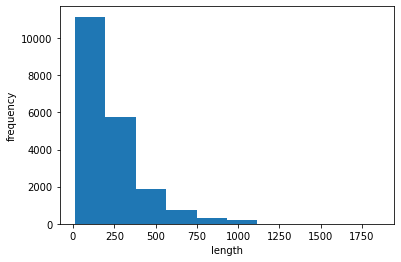

In [7]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [8]:
# 리뷰는 대부분 짧음 -> 100개의 단어만 사용해 분석해보자
# 이런 리뷰들의 길이를 100에 맞추기 위해 패딩이 필요 하지만 패키지 존재
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen = 100) # 기본적으로 maxlen보다 긴 시퀀스의 앞부분을 자른다, 뒷부분을 잘라내고 싶다면 truncating = 'post'추가

In [9]:
print(train_seq.shape)

(20000, 100)


In [10]:
val_seq = pad_sequences(val_input, maxlen = 100)

In [11]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape = (100, 500))) # 100은 샘플크기, 500은 뭐임? -> train_seq, val_seq의 문제 : 토큰을 정수로 변환한 데이터를 신경망에 주입하면 큰 정수가 큰 활성화 출력을 만듬
model.add(keras.layers.Dense(1, activation = 'sigmoid')) # 따라서 토큰을 one-hot-encoding으로 변환하는 기술이 필요함 -> keras.utils.to_categorical(), 원핫인코딩으로 표현하기 위해 필요한 배열의 길이가 500ㅍ

In [12]:
train_oh = keras.utils.to_categorical(train_seq)
print(train_oh.shape)

(20000, 100, 500)


In [13]:
val_oh=  keras.utils.to_categorical(val_seq)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

history = model.fit(train_oh, train_target, epochs = 100, batch_size = 64, validation_data = (val_oh, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 31s 86ms/step - loss: 0.6952 - accuracy: 0.5023 - val_loss: 0.6949 - val_accuracy: 0.5016
Epoch 2/100
313/313 [==============================] - 26s 81ms/step - loss: 0.6909 - accuracy: 0.5253 - val_loss: 0.6909 - val_accuracy: 0.5290
Epoch 3/100
313/313 [==============================] - 24s 77ms/step - loss: 0.6808 - accuracy: 0.5734 - val_loss: 0.6711 - val_accuracy: 0.6038
Epoch 4/100
313/313 [==============================] - 25s 78ms/step - loss: 0.6553 - accuracy: 0.6318 - val_loss: 0.6527 - val_accuracy: 0.6390
Epoch 5/100
313/313 [==============================] - 24s 78ms/step - loss: 0.6373 - accuracy: 0.6593 - val_loss: 0.6385 - val_accuracy: 0.6516
Epoch 6/100
313/313 [==============================] - 25s 80ms/step - loss: 0.6203 - accuracy: 0.6842 - val_loss: 0.6213 - val_accuracy: 0.6778
Epoch 7/100
313/313 [==============================] - 24s 76ms/step - loss: 0.6007 - accuracy: 0.7107 - val_loss: 0.6001 - val_ac

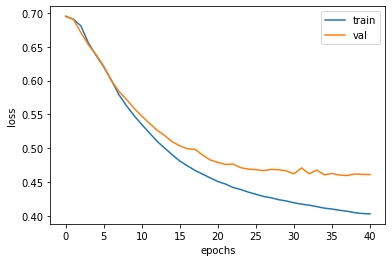

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model2 = model.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_lengths = 100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation = 'sigmoid'))
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model2.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

history = model2.fit(train_oh, train_target, epochs = 100, batch_size = 64, validation_data = (val_oh, val_target), callbacks = [checkpoint_cb, early_stopping_cb])


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [15]:
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words = 500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state = 42)

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen = 100)
val_seq = pad_sequences(val_input, maxlen = 100)

In [17]:
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length = 100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [19]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only = True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model.fit(train_seq, train_target, epochs = 50, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, earlystopping_cb])

Epoch 1/50
313/313 [==============================] - 10s 11ms/step - loss: 0.6924 - accuracy: 0.5531 - val_loss: 0.6917 - val_accuracy: 0.5846
Epoch 2/50
313/313 [==============================] - 3s 9ms/step - loss: 0.6898 - accuracy: 0.6087 - val_loss: 0.6879 - val_accuracy: 0.6586
Epoch 3/50
313/313 [==============================] - 3s 9ms/step - loss: 0.6825 - accuracy: 0.6738 - val_loss: 0.6751 - val_accuracy: 0.6866
Epoch 4/50
313/313 [==============================] - 3s 9ms/step - loss: 0.6406 - accuracy: 0.7017 - val_loss: 0.6066 - val_accuracy: 0.7284
Epoch 5/50
313/313 [==============================] - 3s 9ms/step - loss: 0.5884 - accuracy: 0.7365 - val_loss: 0.5829 - val_accuracy: 0.7380
Epoch 6/50
313/313 [==============================] - 3s 9ms/step - loss: 0.5673 - accuracy: 0.7522 - val_loss: 0.5652 - val_accuracy: 0.7470
Epoch 7/50
313/313 [==============================] - 3s 9ms/step - loss: 0.5492 - accuracy: 0.7627 - val_loss: 0.5495 - val_accuracy: 0.7566
Epoc

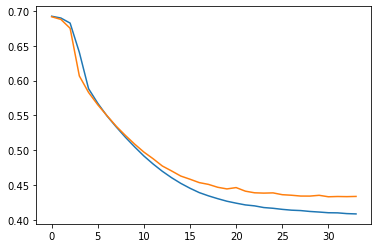

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [22]:
from keras import backend as K

K._get_available_gpus()

['/device:GPU:0']

In [23]:
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length = 100))
model.add(keras.layers.LSTM(8, dropout = 0.3))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only = True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model.fit(train_seq, train_target, epochs = 50, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, earlystopping_cb])

Epoch 1/50
313/313 [==============================] - 5s 10ms/step - loss: 0.6924 - accuracy: 0.5276 - val_loss: 0.6915 - val_accuracy: 0.5652
Epoch 2/50
313/313 [==============================] - 3s 9ms/step - loss: 0.6899 - accuracy: 0.5950 - val_loss: 0.6882 - val_accuracy: 0.6122
Epoch 3/50
313/313 [==============================] - 3s 8ms/step - loss: 0.6844 - accuracy: 0.6277 - val_loss: 0.6804 - val_accuracy: 0.6446
Epoch 4/50
313/313 [==============================] - 3s 8ms/step - loss: 0.6697 - accuracy: 0.6557 - val_loss: 0.6565 - val_accuracy: 0.6704
Epoch 5/50
313/313 [==============================] - 3s 8ms/step - loss: 0.6124 - accuracy: 0.6927 - val_loss: 0.5866 - val_accuracy: 0.7200
Epoch 6/50
313/313 [==============================] - 3s 9ms/step - loss: 0.5683 - accuracy: 0.7323 - val_loss: 0.5582 - val_accuracy: 0.7432
Epoch 7/50
313/313 [==============================] - 3s 9ms/step - loss: 0.5439 - accuracy: 0.7460 - val_loss: 0.5357 - val_accuracy: 0.7590
Epoch

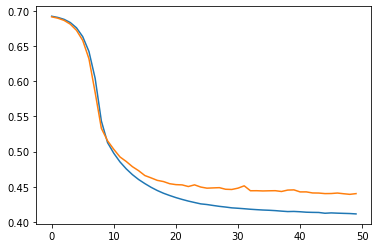

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [25]:

model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length = 100))
model.add(keras.layers.GRU(8))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))


model.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only = True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model.fit(train_seq, train_target, epochs = 50, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, earlystopping_cb])


Epoch 1/50
313/313 [==============================] - 5s 10ms/step - loss: 0.6928 - accuracy: 0.5153 - val_loss: 0.6919 - val_accuracy: 0.5520
Epoch 2/50
313/313 [==============================] - 3s 11ms/step - loss: 0.6910 - accuracy: 0.5695 - val_loss: 0.6900 - val_accuracy: 0.5814
Epoch 3/50
313/313 [==============================] - 3s 8ms/step - loss: 0.6883 - accuracy: 0.5995 - val_loss: 0.6868 - val_accuracy: 0.5944
Epoch 4/50
313/313 [==============================] - 3s 8ms/step - loss: 0.6838 - accuracy: 0.6194 - val_loss: 0.6815 - val_accuracy: 0.6104
Epoch 5/50
313/313 [==============================] - 3s 8ms/step - loss: 0.6763 - accuracy: 0.6348 - val_loss: 0.6726 - val_accuracy: 0.6234
Epoch 6/50
313/313 [==============================] - 3s 9ms/step - loss: 0.6637 - accuracy: 0.6471 - val_loss: 0.6583 - val_accuracy: 0.6378
Epoch 7/50
313/313 [==============================] - 3s 8ms/step - loss: 0.6426 - accuracy: 0.6656 - val_loss: 0.6322 - val_accuracy: 0.6620
Epoc